In [28]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import scipy.cluster.hierarchy as sch
import glob
import re

samplename_dict = {'P1022_1_S3':'PD1',
    'P1022_2_S4':'PD2',
    'P1022_3_S5':'PD3',
    'P1113_1_S18':'PD4',
    'P1113_2_S19':'PD5',
    'P1113_3_S20':'PD6',
    'P13_1_S2':'PD7',
    'P13_2_S3':'PD8',
    'P1016_10X_S6':'PD9'}

def auto_cor(x):
    result = np.correlate(x,x, mode='full')
    return result[result.size/2:]

In [29]:
ctcf_path = '/stor/work/Lambowitz/cdw2854/plasmaDNA/wpsCTCF'
tablenames = glob.glob(ctcf_path + '/*csv')
tablenames = filter(lambda x: re.search('umi2id',x),tablenames)

In [30]:
df = pd.concat(map(pd.read_csv, tablenames))\
    .pipe(lambda d: d[d.samplename.str.contains('unique')]) \
    .pipe(lambda d: d[~d.samplename.str.contains('SQ')]) \
    .pipe(lambda d: d[d['type'].str.contains('Long')]) \
    .assign(corrected_wps = lambda d: d.groupby('samplename')['wps'].transform(scale)) \
    .assign(correlation = lambda d: d.groupby('samplename')['corrected_wps'].transform(auto_cor)) \
    .assign(samplename = lambda d: d.samplename.str.replace('_umi2id_unique','')) \
    .assign(dataset = lambda d: d.samplename.map(samplename_dict))
df.head()

,corrected_wps,position,wps,samplename,type,correlation,dataset
2000,0.476404,-1000,993.807,P1016_10X_S6,Long (120-180 bp),2000.000000,PD9
2001,0.420184,-999,898.807,P1016_10X_S6,Long (120-180 bp),1997.759468,PD9
2002,0.386452,-998,841.807,P1016_10X_S6,Long (120-180 bp),1992.710414,PD9
2003,0.341475,-997,765.807,P1016_10X_S6,Long (120-180 bp),1985.055899,PD9
2004,0.336149,-996,756.807,P1016_10X_S6,Long (120-180 bp),1974.682494,PD9


In [31]:
plot_matrix = df\
    .pipe(pd.pivot_table, index='position', 
          columns='dataset', values='corrected_wps')\
    .corr()\
    .reset_index() \
    .drop('dataset',axis=1)

plot_matrix

dataset,PD1,PD2,PD3,PD4,PD5,PD6,PD7,PD8,PD9
0,1.000000,0.988418,0.976922,0.984490,0.994472,0.978636,0.962756,0.953133,0.963276
1,0.988418,1.000000,0.959031,0.988504,0.988905,0.983648,0.968327,0.952549,0.959346
2,0.976922,0.959031,1.000000,0.963489,0.972077,0.933875,0.934025,0.931115,0.964057
3,0.984490,0.988504,0.963489,1.000000,0.989935,0.981845,0.984268,0.969799,0.976954
4,0.994472,0.988905,0.972077,0.989935,1.000000,0.985031,0.974097,0.961011,0.971439
5,0.978636,0.983648,0.933875,0.981845,0.985031,1.000000,0.974237,0.959738,0.957530
6,0.962756,0.968327,0.934025,0.984268,0.974097,0.974237,1.000000,0.970465,0.967142
7,0.953133,0.952549,0.931115,0.969799,0.961011,0.959738,0.970465,1.000000,0.960973
8,0.963276,0.959346,0.964057,0.976954,0.971439,0.957530,0.967142,0.960973,1.000000


In [37]:
def dendro_sample(plot_matrix):
    cluster_method = 'ward'
    Z=sch.linkage(plot_matrix, method = cluster_method)
    d = sch.dendrogram(Z, orientation='left', 
                       no_labels=True, no_plot=True,
                      color_threshold = 0.5*np.max(Z[:,2]))
    return d


def plot_correlation_matrix(plot_matrix, ax, ax_colorbar):
    Z = dendro_sample(plot_matrix)
    im = ax.imshow(plot_matrix.values[:,Z['leaves']][Z['leaves'],:],
          cmap='viridis', 
          aspect='auto',
          vmin = 0.9,
          vmax=1)
    ticknames = plot_matrix.columns[Z['leaves']]
    ax.xaxis.set_ticks(range(9))
    ax.yaxis.set_ticks(range(9))
    xt = ax.set_xticklabels(ticknames)
    yt = ax.set_yticklabels(ticknames)
    sp = [ax.spines[d].set_visible(False) for d in ['top','left','right','bottom']]
    plt.colorbar(im, cax=ax_colorbar)
    ax_colorbar.set_ylabel(r"Pearson's $\rho$ for scaled WPS", rotation=270)
    ax_colorbar.yaxis.set_label_coords(5,0.5)
    #ax_colorbar.yaxis.set_ticks(np.arange(0.9,1.01,0.01))
    #ax_colorbar.set_yticklabels(np.arange(0.9,1.01,0.01))
    sp = [ax_colorbar.spines[d].set_visible(False) for d in ['top','left','right','bottom']]
    plt.savefig('wps_correlation_heatmap.pdf', bbox_inches='tight')

    
def plot_wps(df, ax, ax_colorbar):
    pdf = df.pipe(pd.pivot_table,index='dataset',
                    columns='position',values='corrected_wps')
    Z = dendro_sample(pdf)
    row_names =  pdf.index.values#[Z['leaves']].values
    plot_mat = pdf.values# - plot_mat.min()
    im = ax.imshow(plot_mat,#[Z['leaves'],:], 
               aspect='auto',
               cmap='inferno')
    sp = [ax.spines[d].set_visible(False) for d in ['top','left','right','bottom']]
    ax.yaxis.set_ticks(range(len(row_names)))
    ax.set_yticklabels(row_names)
    ax.xaxis.set_ticks(range(0,2001,250))
    ax.set_xticklabels(np.arange(0,2001,250) - 1000)
    ax.set_xlabel('Position from CTCF binding site (nt)')


    plt.colorbar(im, cax=ax_colorbar)
    ax_colorbar.set_ylabel(r"Scaled WPS", rotation=270)
    ax_colorbar.yaxis.set_label_coords(4.5,0.5)
 

Plotted:  wps_correlation_heatmap.pdf


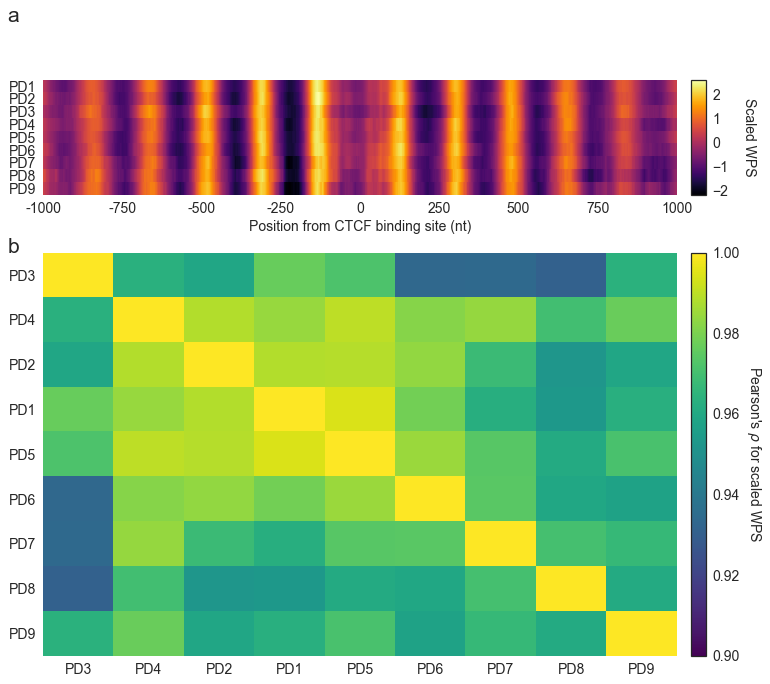

In [38]:
fontsize=14
sns.set_style('white')
font_kw = {'family':'sans-serif',
           'sans-serif':'Arial',
          'size':fontsize}
plt.rc('font',**font_kw)
plt.rc('ytick',labelsize=fontsize)
plt.rc('xtick',labelsize=fontsize)
plt.rc('axes',labelsize=fontsize)

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0, 0.8,0.88, 0.2])
ax_colorbar = fig.add_axes([0.9,0.8,0.02,0.2])
plot_wps(df, ax, ax_colorbar)
ax = fig.add_axes([0, 0, 0.88, 0.7])
ax_colorbar = fig.add_axes([0.9,0,0.02,0.7])
plot_correlation_matrix(plot_matrix, ax, ax_colorbar)
fig.text(-0.05,1.1, 'a', fontsize=fontsize +7)
fig.text(-0.05,0.7, 'b', fontsize=fontsize +7)

figurename = 'wps_correlation_heatmap.pdf'
fig.savefig(figurename, bbox_inches='tight')
print 'Plotted: ', figurename